In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Imports for arithmetic calculations and data frame manipulation
import math
import numpy as np
import pandas as pd

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

#Imports for preprocessing
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

#Imports for modeling and evaluation
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE


#Imports for user defined functions
import wrangle as wr
import explore as ex
import evaluate as ev

## Acquire Prepped Data

In [2]:
train, validate, test = wr.wrangle_who()
train.shape, validate.shape, test.shape

((1645, 22), (705, 22), (588, 22))

In [3]:
train.head()

,country,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,...,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1to19_years,thinness_5to9_years,income_composition_of_resources,schooling,developing
1782,Myanmar,2013,66.2,22.0,42,0.700000,38.337935,75.000000,1010,22.1,...,2.16000,75.0,0.4,1168.839470,51448196.0,12.9,13.2,0.540,9.1,1
946,Gabon,2015,66.0,229.0,2,4.602861,0.000000,8.000000,27,36.3,...,5.93819,8.0,2.7,7388.984144,193175.0,6.1,5.9,0.694,12.6,1
1682,Mauritius,2000,71.0,177.0,0,4.600000,336.321333,88.000000,0,25.3,...,3.78000,88.0,0.1,3861.324140,1186873.0,8.1,8.1,0.667,12.1,1
2629,Togo,2003,54.7,355.0,15,1.020000,2.995960,80.940461,295,17.9,...,5.00000,72.0,5.2,31.437144,539141.0,8.8,8.7,0.428,9.9,1
422,Burundi,2009,56.2,338.0,23,4.050000,2.030495,94.000000,305,15.7,...,6.96000,94.0,2.4,24.944652,848931.0,7.8,7.8,0.336,8.6,1


## Data Preprocessing

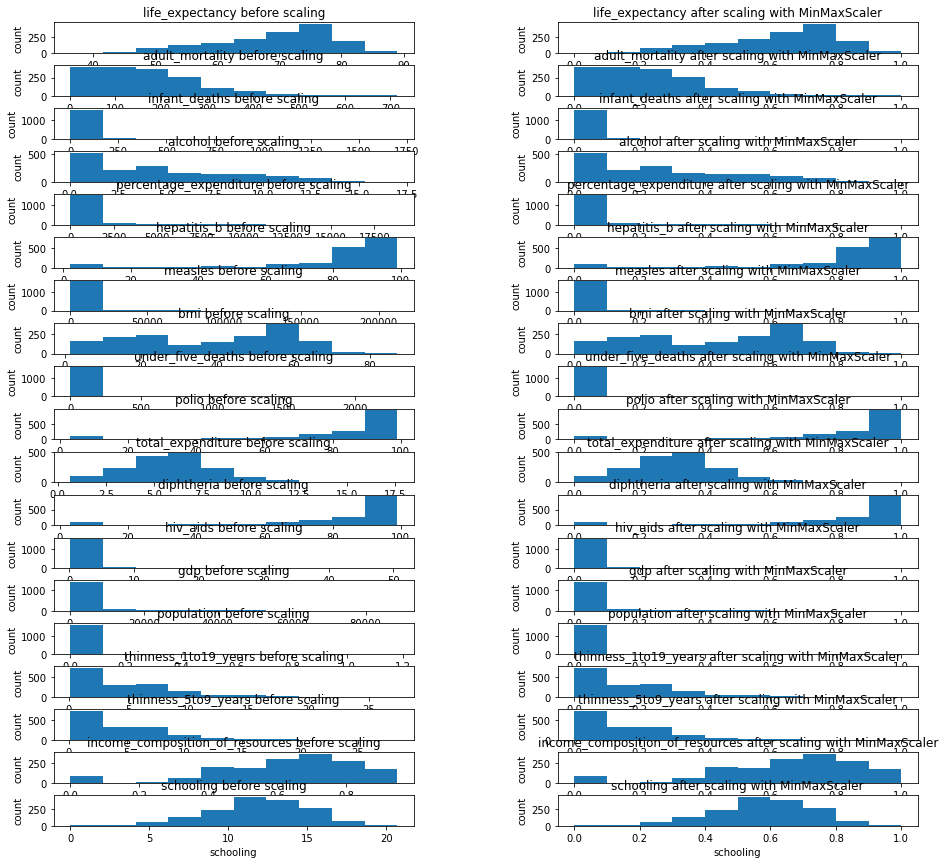

In [4]:
# Visualize scaling of data before actually scaling
cols_to_scale = list(train.drop(columns = ['country', 'developing', 'year']).columns)
wr.visualize_scaler(scaler=MinMaxScaler(), df=train, target_columns = cols_to_scale)
None

*Distributions look relatively similar after scaling so I will move forward with the MinMax Scaler.*

In [5]:
# Scale all 3 splits with MinMax Scaler
train_scaled, validate_scaled, test_scaled = wr.scale_data(train, validate, test)
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((1645, 22), (705, 22), (588, 22))

In [6]:
# Sanity check 
train_scaled.head()

,country,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,...,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1to19_years,thinness_5to9_years,income_composition_of_resources,schooling,developing
1782,Myanmar,2013,0.567362,0.029412,0.024706,0.040636,0.002037,0.752577,0.004760,0.240978,...,0.089086,0.750000,0.005941,0.013179,0.043612,0.468864,0.462898,0.569620,0.439614,1
946,Gabon,2015,0.563567,0.319328,0.001176,0.270487,0.000000,0.061856,0.000127,0.406286,...,0.311988,0.052083,0.051485,0.083413,0.000164,0.219780,0.204947,0.732068,0.608696,1
1682,Mauritius,2000,0.658444,0.246499,0.000000,0.270318,0.017868,0.886598,0.000000,0.278231,...,0.184661,0.885417,0.000000,0.043581,0.001006,0.293040,0.282686,0.703586,0.584541,1
2629,Togo,2003,0.349146,0.495798,0.008824,0.059482,0.000159,0.813819,0.001390,0.192084,...,0.256637,0.718750,0.100990,0.000336,0.000457,0.318681,0.303887,0.451477,0.478261,1
422,Burundi,2009,0.377609,0.471989,0.013529,0.237927,0.000108,0.948454,0.001437,0.166473,...,0.372271,0.947917,0.045545,0.000263,0.000720,0.282051,0.272085,0.354430,0.415459,1


**I'll create X variables that include all features except country and year. I will subset when modeling to only include what I determined as top drivers in exploration.**

In [7]:
#First Iteration - split into X and Y for scaled and unscaled data

#Unscaled data
X_train, y_train = train.drop(columns=['life_expectancy', 'year', 'country']), train.life_expectancy
X_validate, y_validate = validate.drop(columns=['life_expectancy', 'year', 'country']), validate.life_expectancy
X_test, y_test = test.drop(columns=['life_expectancy', 'year', 'country']), test.life_expectancy

#Scaled data
X_train_scaled, y_train_scaled = train_scaled.drop(columns=['life_expectancy', 'year', 'country']), train_scaled.life_expectancy
X_validate_scaled, y_validate_scaled = validate_scaled.drop(columns=['life_expectancy', 'year', 'country']), validate_scaled.life_expectancy
X_test_scaled, y_test_scaled = test_scaled.drop(columns=['life_expectancy', 'year', 'country']), test_scaled.life_expectancy

In [8]:
#Sanity Checks
X_train.head()

,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1to19_years,thinness_5to9_years,income_composition_of_resources,schooling,developing
1782,22.0,42,0.700000,38.337935,75.000000,1010,22.1,55,76.0,2.16000,75.0,0.4,1168.839470,51448196.0,12.9,13.2,0.540,9.1,1
946,229.0,2,4.602861,0.000000,8.000000,27,36.3,3,79.0,5.93819,8.0,2.7,7388.984144,193175.0,6.1,5.9,0.694,12.6,1
1682,177.0,0,4.600000,336.321333,88.000000,0,25.3,0,88.0,3.78000,88.0,0.1,3861.324140,1186873.0,8.1,8.1,0.667,12.1,1
2629,355.0,15,1.020000,2.995960,80.940461,295,17.9,22,72.0,5.00000,72.0,5.2,31.437144,539141.0,8.8,8.7,0.428,9.9,1
422,338.0,23,4.050000,2.030495,94.000000,305,15.7,34,96.0,6.96000,94.0,2.4,24.944652,848931.0,7.8,7.8,0.336,8.6,1


In [9]:
X_train_scaled.head()

,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1to19_years,thinness_5to9_years,income_composition_of_resources,schooling,developing
1782,0.029412,0.024706,0.040636,0.002037,0.752577,0.004760,0.240978,0.023913,0.760417,0.089086,0.750000,0.005941,0.013179,0.043612,0.468864,0.462898,0.569620,0.439614,1
946,0.319328,0.001176,0.270487,0.000000,0.061856,0.000127,0.406286,0.001304,0.791667,0.311988,0.052083,0.051485,0.083413,0.000164,0.219780,0.204947,0.732068,0.608696,1
1682,0.246499,0.000000,0.270318,0.017868,0.886598,0.000000,0.278231,0.000000,0.885417,0.184661,0.885417,0.000000,0.043581,0.001006,0.293040,0.282686,0.703586,0.584541,1
2629,0.495798,0.008824,0.059482,0.000159,0.813819,0.001390,0.192084,0.009565,0.718750,0.256637,0.718750,0.100990,0.000336,0.000457,0.318681,0.303887,0.451477,0.478261,1
422,0.471989,0.013529,0.237927,0.000108,0.948454,0.001437,0.166473,0.014783,0.968750,0.372271,0.947917,0.045545,0.000263,0.000720,0.282051,0.272085,0.354430,0.415459,1


## Feature Selection

In [10]:
def select_rfe(X_train_scaled, y_train, k, return_rankings=False, model=LinearRegression()):
    # Use the passed model, LinearRegression by default
    rfe = RFE(model, n_features_to_select=k)
     # fit the data using RFE
    rfe.fit(X_train_scaled, y_train)
    # get mask of columns selected as list
    feature_mask = X_train_scaled.columns[rfe.support_].tolist()
    if return_rankings:
        rankings = pd.Series(dict(zip(X_train_scaled.columns, rfe.ranking_)))
        return feature_mask, rankings
    else:
        return feature_mask

In [11]:
features_to_use, feature_rankings = select_rfe(X_train_scaled, y_train, 5, return_rankings=True)

In [12]:
#print(feature_rankings.sort_values())
print(' \n Use the following features: \n')
print(feature_rankings)

 
 Use the following features: 

adult_mortality                     1
infant_deaths                       1
alcohol                            14
percentage_expenditure              2
hepatitis_b                        13
measles                             6
bmi                                 4
under_five_deaths                   1
polio                               5
total_expenditure                  12
diphtheria                          8
hiv_aids                            1
gdp                                 9
population                         10
thinness_1to19_years                7
thinness_5to9_years                15
income_composition_of_resources     3
schooling                           1
developing                         11
dtype: int64


*Some of these features line up well with what I determined to be top drivers. I notice that some of these features seem to measure very similar things such as infant_deaaths and under_five_deaths. I'll make models that use RFE selected features as well as models where I make judgement calls on best features.*

## Establish Baseline

**I'll calculate both the mean and median of life_expectancy, create predictions using those and evaluate using RMSE to choose which to use as a baseline model.**

In [13]:
#First convert y_train into Dataframes so the baselines can be easily calculated with pandas
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test =pd.DataFrame(y_test)

# 1. Predict mean life expectancy
le_pred_mean = y_train.life_expectancy.mean()
y_train['le_pred_mean'] = le_pred_mean
y_validate['le_pred_mean'] = le_pred_mean

# 2. Predict median life expectancy 
le_pred_median = y_train.life_expectancy.median()
y_train['le_pred_median'] = le_pred_median
y_validate['le_pred_median'] = le_pred_median

# 3. RMSE of le_pred_mean
rmse_train = mean_squared_error(y_train.life_expectancy, y_train.le_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.life_expectancy, y_validate.le_pred_mean) ** 0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of le_pred_median
rmse_train1 = mean_squared_error(y_train.life_expectancy, y_train.le_pred_median) ** .5
rmse_validate1 = mean_squared_error(y_validate.life_expectancy, y_validate.le_pred_median) ** .5
print('-----------')
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train1, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate1, 2))


RMSE using Mean
Train/In-Sample:  9.34 
Validate/Out-of-Sample:  9.9
-----------
RMSE using Median
Train/In-Sample:  9.76 
Validate/Out-of-Sample:  10.28


**I'll move forward with the mean as my baseline since it had the better performing RMSE.**

In [14]:
## Create a dataframe to hold my model predictions to help with side by side evaluation and visualization
predictions = y_validate.copy()
predictions = predictions.rename(columns={'life_expectancy':'actual'})
predictions.head()

,actual,le_pred_mean,le_pred_median
2561,66.1,69.142462,72.0
545,83.0,69.142462,72.0
2178,73.1,69.142462,72.0
144,72.7,69.142462,72.0
2338,74.3,69.142462,72.0


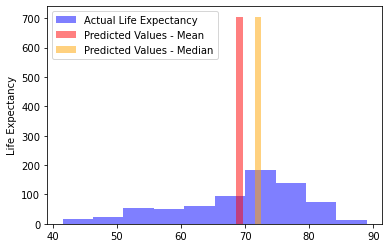

In [15]:
# Visualize baseline performance
# plot to visualize actual vs predicted. 
plt.hist(predictions.actual, color='blue', alpha=.5, label="Actual Life Expectancy")
plt.hist(predictions.le_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Values - Mean")
plt.hist(predictions.le_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Values - Median")
plt.ylabel("Life Expectancy")
plt.legend()
plt.show()

**Not quite sure why this visualization isn't working.**

## Create Regression Models

In [16]:
# add the mean baseline to a df to help evaluate models side by side
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_outofsample': rmse_validate,
    'r^2_outofsample': explained_variance_score(y_validate.life_expectancy, y_validate.life_expectancy)}])

In [17]:
metric_df

,model,rmse_outofsample,r^2_outofsample
0,mean_baseline,9.904188,1.0


In [18]:
# Create lists with different feature selections
#This list contains the top drivers I determine from exploratory analysis
features = ['income_composition_of_resources', 'schooling', 'hiv_aids', 'gdp', 'developing', 'bmi']
#This list contains the features selected using Recursive Feature Elimination
rfe_features = ['infant_deaths', 'adult_mortality', 'under_five_deaths', 'hiv_aids', 'schooling']

### Model 1 - Simple Model (Ordinary Least Squares)

In [19]:
## Model 1 - Simple Model -- Ordinary Least Squares

#Create model
lm = LinearRegression(normalize = True)

# Fit the model on train
# use only the features we selected
lm.fit(X_train_scaled[features], y_train.life_expectancy)

#Predict on train and validate
# predict train
y_train['le_pred_ols'] = lm.predict(X_train_scaled[features])
# predict validate
y_validate['le_pred_ols'] = lm.predict(X_validate_scaled[features])

# Calculate RMSE
train_rmse1 = ev.rmse(y_train.life_expectancy, y_train.le_pred_ols)
validate_rmse1 = ev.rmse(y_validate.life_expectancy, y_validate.le_pred_ols)

#Calculate R^2 Score
r2_train1 = r2_score(y_train.life_expectancy, y_train.le_pred_ols)
r2_validate1 = r2_score(y_validate.life_expectancy, y_validate.le_pred_ols)

print("RMSE using OLS\nTrain/In-Sample: ", train_rmse1, 
      "\nValidate/Out-of-Sample: ", validate_rmse1)

print("R2 Score using OLS\nTrain/In-Sample: ", r2_train1, 
      "\nValidate/Out-of-Sample: ", r2_validate1)

RMSE using OLS
Train/In-Sample:  4.813843994943346 
Validate/Out-of-Sample:  5.100214633055507
R2 Score using OLS
Train/In-Sample:  0.7340776494981572 
Validate/Out-of-Sample:  0.7347985876680169


In [20]:
# Add to predictions df
predictions['le_pred_ols'] = y_validate.le_pred_ols
predictions.head()

,actual,le_pred_mean,le_pred_median,le_pred_ols
2561,66.1,69.142462,72.0,67.841448
545,83.0,69.142462,72.0,78.098469
2178,73.1,69.142462,72.0,70.736711
144,72.7,69.142462,72.0,72.428017
2338,74.3,69.142462,72.0,77.079066


In [21]:
# add model's performance to metric df
metric_df = metric_df.append(
    {
    'model': 'ols',
    'rmse_outofsample': validate_rmse1,
        'r^2_outofsample': r2_validate1}, ignore_index=True)

In [22]:
# Is it better than baseline?
ev.better_than_baseline(predictions.actual, predictions.le_pred_ols)

True

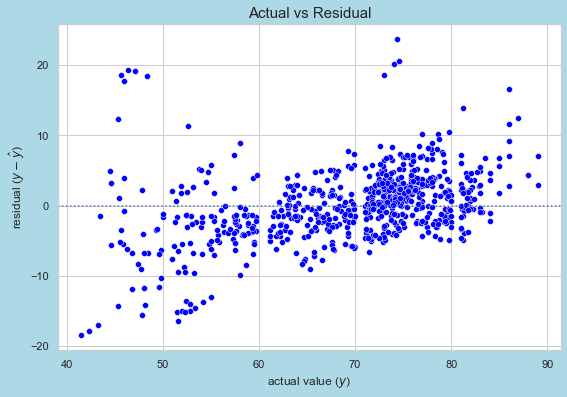

In [23]:
# Visualize by plotting residuals
ev.plot_residuals(predictions.actual, predictions.le_pred_ols, predictions)

### Model 2 - LASSO + LARS

In [24]:
## Model 2 -- Set up a loop that creates LassoLars models using different values for the alpha

for i in range(1, 25, 5):
    #Create model
    lars = LassoLars(alpha = i)
    
    #Fit model
    lars.fit(X_train_scaled[features], y_train.life_expectancy)
    
    #Make predictions and add to data frame
    predictions[f'lars_alpha_{i}'] = lars.predict(X_validate_scaled[features])
    
    #Calculate RMSE
    validate_rmse = ev.rmse(predictions.actual, predictions[f'lars_alpha_{i}'])
    
    #Calculate R^2 score
    validate_r2 = (ev.r2_score(predictions.actual, predictions[f'lars_alpha_{i}'])) * 10000
    
    print(f'\nRMSE using LassoLars, alpha = {i}')
    print("\nValidate/Out-of-Sample: ", round(validate_rmse, 2))
    
    print(f'\nR^2 Score using LassoLars, alpha = {i}')
    print("\nValidate/Out-of-Sample: ", validate_r2)
    


RMSE using LassoLars, alpha = 1

Validate/Out-of-Sample:  9.9

R^2 Score using LassoLars, alpha = 1

Validate/Out-of-Sample:  0.8445125342382884

RMSE using LassoLars, alpha = 6

Validate/Out-of-Sample:  9.9

R^2 Score using LassoLars, alpha = 6

Validate/Out-of-Sample:  0.8445125342382884

RMSE using LassoLars, alpha = 11

Validate/Out-of-Sample:  9.9

R^2 Score using LassoLars, alpha = 11

Validate/Out-of-Sample:  0.8445125342382884

RMSE using LassoLars, alpha = 16

Validate/Out-of-Sample:  9.9

R^2 Score using LassoLars, alpha = 16

Validate/Out-of-Sample:  0.8445125342382884

RMSE using LassoLars, alpha = 21

Validate/Out-of-Sample:  9.9

R^2 Score using LassoLars, alpha = 21

Validate/Out-of-Sample:  0.8445125342382884


In [25]:
predictions

,actual,le_pred_mean,le_pred_median,le_pred_ols,lars_alpha_1,lars_alpha_6,lars_alpha_11,lars_alpha_16,lars_alpha_21
2561,66.1,69.142462,72.0,67.841448,69.142462,69.142462,69.142462,69.142462,69.142462
545,83.0,69.142462,72.0,78.098469,69.142462,69.142462,69.142462,69.142462,69.142462
2178,73.1,69.142462,72.0,70.736711,69.142462,69.142462,69.142462,69.142462,69.142462
144,72.7,69.142462,72.0,72.428017,69.142462,69.142462,69.142462,69.142462,69.142462
2338,74.3,69.142462,72.0,77.079066,69.142462,69.142462,69.142462,69.142462,69.142462
...,...,...,...,...,...,...,...,...,...
1860,78.6,69.142462,72.0,81.190834,69.142462,69.142462,69.142462,69.142462,69.142462
1753,72.8,69.142462,72.0,69.548172,69.142462,69.142462,69.142462,69.142462,69.142462
2342,73.7,69.142462,72.0,75.709421,69.142462,69.142462,69.142462,69.142462,69.142462
1464,74.7,69.142462,72.0,73.653053,69.142462,69.142462,69.142462,69.142462,69.142462


*Performance using different alpha values seems identical. I'll use the model with an alpha value of 1 to add to my metric df.*

In [26]:
# add model's performance to metric df
metric_df = metric_df.append(
    {
    'model': 'lasso_lars',
    'rmse_outofsample': validate_rmse,
        'r^2_outofsample': validate_r2}, ignore_index=True)

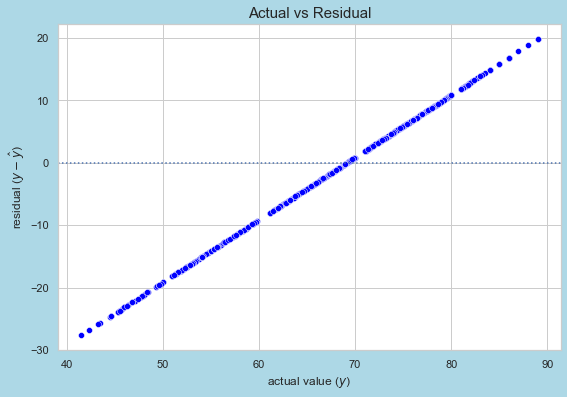

In [27]:
# Visualize by plotting residuals
ev.plot_residuals(predictions.actual, predictions.lars_alpha_1, predictions)

### Model 3 - Generalized Linear Model

In [28]:
## Model 3 - TweedieRegressor GLM

#Create model
glm = TweedieRegressor(power=1, alpha=0)

# Fit the model on train
# use only the features we selected
glm.fit(X_train_scaled[features], y_train.life_expectancy)

#Predict on train and validate
# predict train
y_train['le_pred_glm'] = glm.predict(X_train_scaled[features])
# predict validate
y_validate['le_pred_glm'] = glm.predict(X_validate_scaled[features])

# Calculate RMSE
train_rmse3 = ev.rmse(y_train.life_expectancy, y_train.le_pred_glm)
validate_rmse3 = ev.rmse(y_validate.life_expectancy, y_validate.le_pred_glm)

#Calculate R^2 Score
r2_train3 = r2_score(y_train.life_expectancy, y_train.le_pred_glm)
r2_validate3 = r2_score(y_validate.life_expectancy, y_validate.le_pred_glm)

print("RMSE using OLS\nTrain/In-Sample: ", train_rmse3, 
      "\nValidate/Out-of-Sample: ", validate_rmse3)

print("R2 Score using OLS\nTrain/In-Sample: ", r2_train3, 
      "\nValidate/Out-of-Sample: ", r2_validate3)

RMSE using OLS
Train/In-Sample:  4.732480581705396 
Validate/Out-of-Sample:  4.928815988414572
R2 Score using OLS
Train/In-Sample:  0.7429909012449643 
Validate/Out-of-Sample:  0.7523238798535985


In [29]:
# Add to predictions df
predictions['le_pred_glm'] = y_validate.le_pred_glm

In [30]:
# add model's performance to metric df
metric_df = metric_df.append(
    {
    'model': 'tweedie_glm',
    'rmse_outofsample': validate_rmse3,
        'r^2_outofsample': r2_validate3}, ignore_index=True)

### Model 4 - Polynomial Regression

#### Create the Polynomial Features

In [31]:
## Create the polynomial features

# Create polynomial features
pf = PolynomialFeatures(degree=2)

# fit to my features and create a new version of X_train with transformed features
X_train_poly = pf.fit_transform(X_train_scaled[features])

# Transform features on X_validate and X_test
X_validate_poly = pf.transform(X_validate_scaled[features])
X_test_poly = pf.transform(X_test_scaled[features])

In [34]:
## Model 4 - Polynomial Regression Model

#Create model
lm2 = LinearRegression(normalize=True)

# Fit the model on train
# use only the features we selected
lm2.fit(X_train_poly, y_train.life_expectancy)

#Predict on train and validate
# predict train
y_train['le_pred_poly'] = lm2.predict(X_train_poly)
# predict validate
y_validate['le_pred_poly'] = lm2.predict(X_validate_poly)

# Calculate RMSE
train_rmse4 = ev.rmse(y_train.life_expectancy, y_train.le_pred_poly)
validate_rmse4= ev.rmse(y_validate.life_expectancy, y_validate.le_pred_poly)

#Calculate R^2 Score
r2_train4 = r2_score(y_train.life_expectancy, y_train.le_pred_poly)
r2_validate4 = r2_score(y_validate.life_expectancy, y_validate.le_pred_poly)

print("RMSE using OLS\nTrain/In-Sample: ", train_rmse4, 
      "\nValidate/Out-of-Sample: ", validate_rmse4)

print("R2 Score using OLS\nTrain/In-Sample: ", r2_train4, 
      "\nValidate/Out-of-Sample: ", r2_validate4)

RMSE using OLS
Train/In-Sample:  3.9063342019978085 
Validate/Out-of-Sample:  4.037805237049329
R2 Score using OLS
Train/In-Sample:  0.8248905396468029 
Validate/Out-of-Sample:  0.8337775571147898


In [35]:
# Add to predictions df
predictions['le_pred_poly'] = y_validate.le_pred_poly

In [38]:
# add model's performance to metric df
metric_df = metric_df.append(
    {
    'model': 'polynomial',
    'rmse_outofsample': validate_rmse4,
        'r^2_outofsample': r2_validate4}, ignore_index=True)

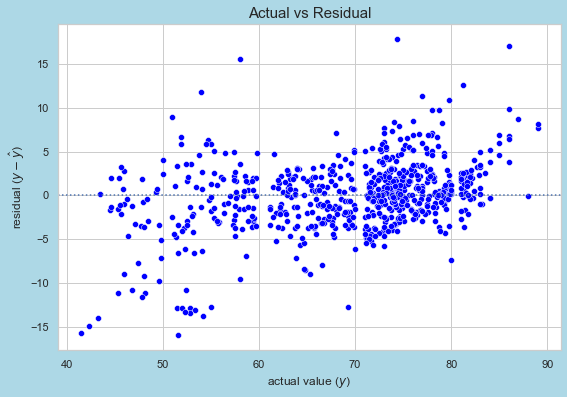

In [39]:
# Visualize by plotting residuals
ev.plot_residuals(predictions.actual, predictions.le_pred_poly, predictions)

## Evaluate and Select Best Model

In [40]:
metric_df

,model,rmse_outofsample,r^2_outofsample
0,mean_baseline,9.904188,1.000000
1,ols,5.100215,0.734799
2,lasso_lars,9.904188,0.844513
3,tweedie_glm,4.928816,0.752324
4,polynomial,4.037805,0.833778
